Calculating Wind Shear
======================

This example plots calculates the 850-500 hPa Bulk Wind Shear

Plotting over a regional domain, accessing the Best Collection of GFS from the
Unidata Thredds server, plots MSLP (hPa), 850-hPa Wind Vector (m/s), 500-hPa
Wind Vector (m/s), and the Wind Shear between the two layers (m/s)

## Import necessary packages

In [1]:
from datetime import datetime

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from metpy.units import units
import numpy as np
import scipy.ndimage as ndimage
from siphon.catalog import TDSCatalog
from xarray.backends import NetCDF4DataStore
import xarray as xr

## Obtain data

In [2]:
# Construct a TDSCatalog instance pointing to the gfs dataset
best_gfs = TDSCatalog('http://thredds.ucar.edu/thredds/catalog/grib/'
                      'NCEP/GFS/Global_0p5deg/catalog.xml')

# Interface with the Best GFS Half Degree Forecast Time Series dataset
# via NCSS directly
ncss = best_gfs.datasets['Best GFS Half Degree Forecast Time Series'].subset()

## First Query for MSLP

In [5]:
# Create our NCSS query with desired specifications
query = ncss.query()
query.lonlat_box(north=50, south=30, east=-80, west=-115)
query.time(datetime.utcnow())
query.accept('netcdf4')
query.variables('MSLP_Eta_model_reduction_msl')

# Obtain the data we've queried for as a netcdf4-python dataset
data = ncss.get_data(query)

# Make into an xarray Dataset object
ds = xr.open_dataset(NetCDF4DataStore(data)).metpy.parse_cf()

# Pull out the variables you want to use
mslp_var = ds.MSLP_Eta_model_reduction_msl
time_var = ds.MSLP_Eta_model_reduction_msl.metpy.time
lat_var = ds.latitude
lon_var = ds.longitude

## Second Query for 850-hPa data

In [6]:
# Request data for 850-hPa winds
# First clear the query's variables from previous query for MSLP
query.var = set()
query.vertical_level(85000)
query.variables('u-component_of_wind_isobaric',
                'v-component_of_wind_isobaric')

data = ncss.get_data(query)

# Make into an xarray Dataset object
ds_wind = xr.open_dataset(NetCDF4DataStore(data)).metpy.parse_cf()

u_wind_var850 = ds_wind['u-component_of_wind_isobaric']
v_wind_var850 = ds_wind['v-component_of_wind_isobaric']

Third Query for 500-hPa data

In [7]:
# Request data for 500-hPa winds
# First clear the query's variables from previous query for 850-hPa data
query.var = set()
query.vertical_level(50000)
query.variables('u-component_of_wind_isobaric',
                'v-component_of_wind_isobaric')

data = ncss.get_data(query)

# Make into an xarray Dataset object
ds_wind = xr.open_dataset(NetCDF4DataStore(data)).metpy.parse_cf()

u_wind_var500 = ds_wind['u-component_of_wind_isobaric']
v_wind_var500 = ds_wind['v-component_of_wind_isobaric']

## Data Manipulation

In [8]:
# Get actual data values and remove any size 1 dimensions
lat = lat_var.values.squeeze()
lon = lon_var.values.squeeze()
mslp = mslp_var.metpy.convert_units('hPa').squeeze()
u_wind850 = u_wind_var850.squeeze()
v_wind850 = v_wind_var850.squeeze()
u_wind500 = u_wind_var500.squeeze()
v_wind500 = v_wind_var500.squeeze()

# Convert number of hours since the reference time into an actual date
time = time_var.values.astype('datetime64[ms]').astype('O').squeeze()

# Combine 1D latitude and longitudes into a 2D grid of locations
lon_2d, lat_2d = np.meshgrid(lon, lat)

# Smooth mslp data
mslp = ndimage.gaussian_filter(mslp, sigma=3, order=0)

Begin making figure

/var/folders/fp/_l45s1m93s5009vb713pyg580000gn/T/ipykernel_52398/1356670571.py:43: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  legend.legendHandles[0].set_color('gold')
/var/folders/fp/_l45s1m93s5009vb713pyg580000gn/T/ipykernel_52398/1356670571.py:44: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  legend.legendHandles[1].set_color('cornflowerblue')
/var/folders/fp/_l45s1m93s5009vb713pyg580000gn/T/ipykernel_52398/1356670571.py:45: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  legend.legendHandles[2].set_color('deeppink')
/Users/kgoebber/miniconda3/envs/main/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: i

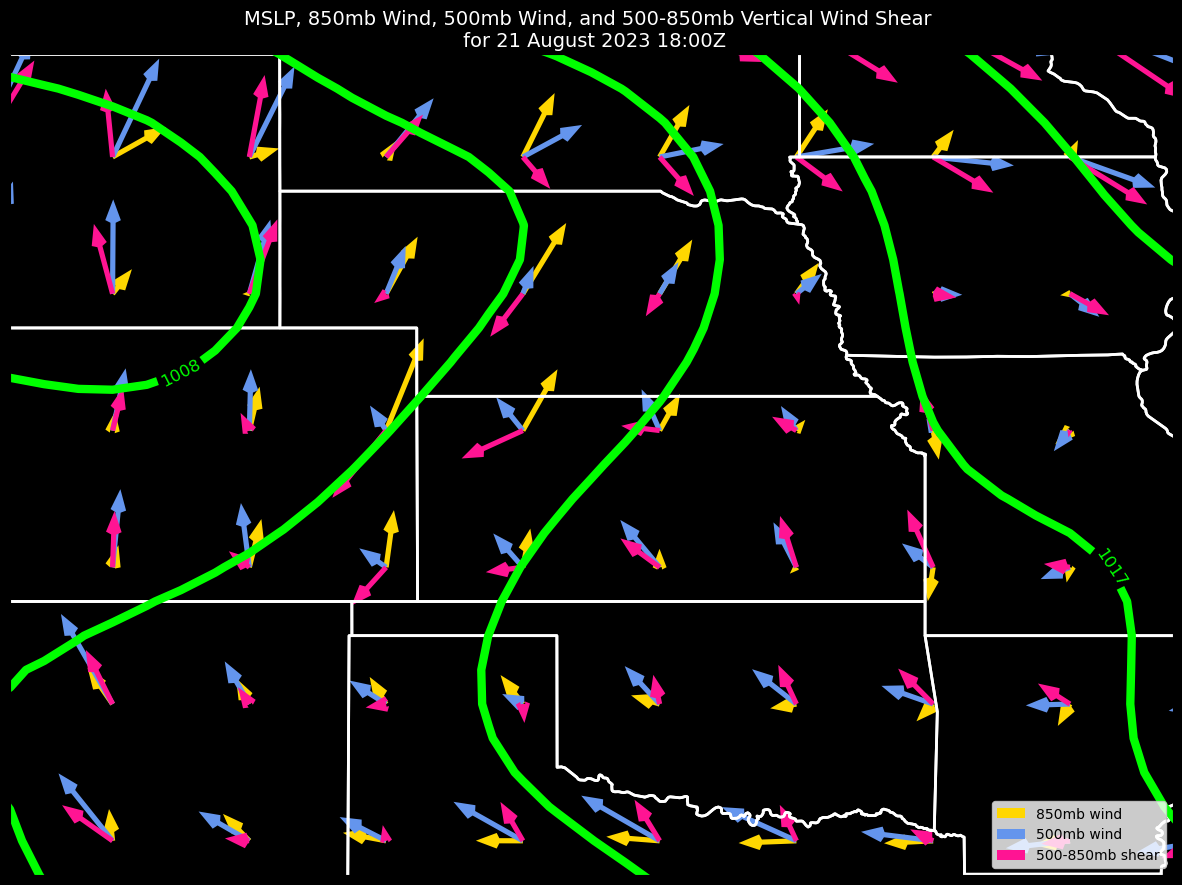

In [10]:
# Create new figure
fig = plt.figure(figsize=(15, 12), facecolor='black')

# Add the map and set the extent
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-108., -91., 33., 45.])
ax.patch.set_fill(False)

# Add state boundaries to plot
ax.add_feature(cfeature.STATES, edgecolor='white', linewidth=2)

# Contour the MSLP
c = ax.contour(lon_2d, lat_2d, mslp, colors='lime', linewidths=6)
ax.clabel(c, fontsize=12, inline=1, inline_spacing=4, fmt='%i')

wslice = slice(1, None, 4)
# Plot 850-hPa wind vectors
vectors850 = ax.quiver(lon_2d[wslice, wslice], lat_2d[wslice, wslice],
                       u_wind850[wslice, wslice], v_wind850[wslice, wslice],
                       headlength=4, headwidth=3, angles='xy',
                       scale_units='xy', scale=12, color='gold',
                       label='850mb wind')

# Plot 500-hPa wind vectors
vectors500 = ax.quiver(lon_2d[wslice, wslice], lat_2d[wslice, wslice],
                       u_wind500[wslice, wslice], v_wind500[wslice, wslice],
                       headlength=4, headwidth=3, angles='xy',
                       scale_units='xy', scale=12, color='cornflowerblue',
                       label='500mb wind')

# Plot 500-850 shear
shear = ax.quiver(lon_2d[wslice, wslice], lat_2d[wslice, wslice],
                  u_wind500[wslice, wslice] - u_wind850[wslice, wslice],
                  v_wind500[wslice, wslice] - v_wind850[wslice, wslice],
                  headlength=4, headwidth=3, angles='xy', scale_units='xy',
                  scale=12, color='deeppink', label='500-850mb shear')

# Add a legend
ax.legend(('850mb wind', '500mb wind', '500-850mb shear'), loc=4)

# Manually set colors for legend
legend = ax.get_legend()
legend.legendHandles[0].set_color('gold')
legend.legendHandles[1].set_color('cornflowerblue')
legend.legendHandles[2].set_color('deeppink')

# Add a title to the plot
plt.title('MSLP, 850mb Wind, 500mb Wind, and 500-850mb Vertical Wind Shear \n'
          f' for {time:%d %B %Y %H:%MZ}', color='white', size=14);